1.モジュールのインポート

In [11]:
import torch
from PIL import Image
from torchvision import transforms
import clip
from nltk.corpus import wordnet
from datetime import datetime
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import nltk
import matplotlib.pyplot as plt
from datetime import datetime
import os
from pathlib import Path


In [12]:
# nltkのセットアップ
nltk.download('wordnet')

# モデルとトークナイザのロード
device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

def get_image_representation(image_path):
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features

def get_text_similarities(image_features, texts):
    text_tokens = clip.tokenize(texts).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
    similarities = (image_features @ text_features.T) / (image_features.norm(dim=-1) * text_features.norm(dim=-1))
    return similarities[0].cpu().numpy()


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


入力画像の表示

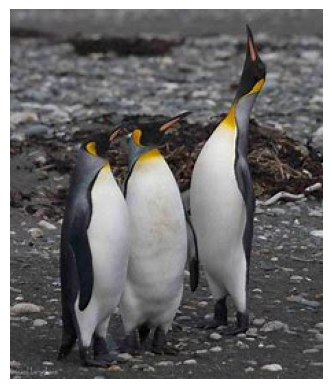

In [13]:
image_path = "/workspace/data/input/three pen.jpg" # 画像パスを指定
image_representation = get_image_representation(image_path)
image = Image.open(image_path)  # 画像ファイルを開く

plt.imshow(image)  # 画像データを表示
plt.axis('off')  # 軸を非表示にする
plt.show()


何の画像かの特定

In [14]:

chunk_size = 5000
total_words = list(set([lemma.name() for synset in wordnet.all_synsets('n') for lemma in synset.lemmas()]))
all_scores = []

# 単語リストをチャンクに分割して処理
for i in range(0, len(total_words), chunk_size):
    chunk_words = total_words[i:i+chunk_size]
    similarity_scores_chunk = get_text_similarities(image_representation, chunk_words)
    all_scores.extend(similarity_scores_chunk)

    # CUDAキャッシュをクリア
    torch.cuda.empty_cache()

# 類似度に基づいてテキストをソート
sorted_words_and_scores = sorted(zip(total_words, all_scores), key=lambda x: x[1], reverse=True)

# トップ3の関連テキストとその類似度を取得して出力
top_words_and_scores = sorted_words_and_scores[:3]
print("Top 3 related words with their similarity scores:")
for word, score in top_words_and_scores:
    print(f"{word}: {score:.4f}")


Top 3 related words with their similarity scores:
crested_penguin: 0.3142
king_penguin: 0.3127
emperor_penguin: 0.3103


数の特定

In [15]:
numwords = ["one", "two", "three", "four", "five", "many"]
scores = get_text_similarities(image_representation, numwords)

# スコアと単語を組み合わせて表示
for Num, score in zip(numwords, scores):
    print(f"{Num}: {score}")


# 最高のスコアを持つ単語を見つける
word_score_pairs = zip(numwords, scores)

highest_scoring_NumWord = max(word_score_pairs, key=lambda pair: pair[1])[0]

# 結果を表示
print(f"highest_scoring_NumWord {highest_scoring_NumWord}")

one: 0.220458984375
two: 0.2161865234375
three: 0.2230224609375
four: 0.21484375
five: 0.2108154296875
many: 0.2099609375
highest_scoring_NumWord three


必要に応じて複数形への変換

In [16]:
# highest_scoring_NumWordが"one"の場合は"a"に置き換え、それ以外は各単語に"s"を追加
if highest_scoring_NumWord == "one":
    highest_scoring_NumWord = "a"
else:
    top_words_and_scores = [(word + "s", score) for word, score in top_words_and_scores]

# 結果を表示
print(f"highest_scoring_NumWord: {highest_scoring_NumWord}")
print("Top 3 related words with their similarity scores:")
for word, score in top_words_and_scores:
    print(f"{word}: {score:.4f}")

highest_scoring_NumWord: three
Top 3 related words with their similarity scores:
crested_penguins: 0.3142
king_penguins: 0.3127
emperor_penguins: 0.3103


感受性語の特定

In [17]:
SensitivityWords = [
    "Cute", "Modern", "Elegant", "Minimalist", "Dynamic", 
    "Vintage", "Bold", "Sleek", "Creative", "Playful", 
    "Innovative", "Classic", "Sophisticated", "Edgy", "Futuristic", 
    "Retro", "Artistic", "Geometric", "Organic", "Abstract"
]
# 類似度スコアの計算
scores = get_text_similarities(image_representation, SensitivityWords)

# スコアと単語を組み合わせて表示
for words, score in zip(SensitivityWords, scores):
    print(f"{words}: {score}")

# スコアに基づいて単語をソートし、上位3つを取得
sorted_words_and_scores = sorted(zip(SensitivityWords, scores), key=lambda x: x[1], reverse=True)
top_SensitivityWords_and_scores = sorted_words_and_scores[:3]

# 結果の表示
print("Top 3 related words with their similarity scores:")
for word, score in top_SensitivityWords_and_scores:
    print(f"{word}: {score:.4f}")


Cute: 0.21240234375
Modern: 0.19970703125
Elegant: 0.1944580078125
Minimalist: 0.1953125
Dynamic: 0.2120361328125
Vintage: 0.19580078125
Bold: 0.21240234375
Sleek: 0.2149658203125
Creative: 0.199462890625
Playful: 0.2158203125
Innovative: 0.1865234375
Classic: 0.1920166015625
Sophisticated: 0.2010498046875
Edgy: 0.1920166015625
Futuristic: 0.17431640625
Retro: 0.189208984375
Artistic: 0.202880859375
Geometric: 0.199951171875
Organic: 0.1971435546875
Abstract: 0.17626953125
Top 3 related words with their similarity scores:
Playful: 0.2158
Sleek: 0.2150
Cute: 0.2124


上位3つの単語からユーザがどの名詞から生成された単語がよいか選択

model_index.json: 100%|██████████| 511/511 [00:00<00:00, 1.25MB/s]
/opt/conda/envs/logo/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:267: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2 via `revision='fp16'`. This behavior is deprecated and will be removed in diffusers v1. One should use `variant='fp16'` instead. However, it appears that stabilityai/stable-diffusion-2 currently does not have the required variant filenames in the 'main' branch. 
 The Diffusers team and community would be very grateful if you could open an issue: https://github.com/huggingface/diffusers/issues/new with the title 'stabilityai/stable-diffusion-2 is missing fp16 files' so that the correct variant file can be added.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found
Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]
diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00

Image 1 saved for word 'Design a logo for three crested_penguins ' at /workspace/data/output/20240513_062515_prompt_Design a logo for three crested_penguins _0.jpg


100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


Image 2 saved for word 'Design a logo for three crested_penguins ' at /workspace/data/output/20240513_062522_prompt_Design a logo for three crested_penguins _1.jpg


100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


Image 1 saved for word 'Design a logo for three king_penguins ' at /workspace/data/output/20240513_062529_prompt_Design a logo for three king_penguins _0.jpg


100%|██████████| 50/50 [00:06<00:00,  7.26it/s]


Image 2 saved for word 'Design a logo for three king_penguins ' at /workspace/data/output/20240513_062536_prompt_Design a logo for three king_penguins _1.jpg


100%|██████████| 50/50 [00:06<00:00,  7.36it/s]


Image 1 saved for word 'Design a logo for three emperor_penguins ' at /workspace/data/output/20240513_062543_prompt_Design a logo for three emperor_penguins _0.jpg


100%|██████████| 50/50 [00:06<00:00,  7.40it/s]


Image 2 saved for word 'Design a logo for three emperor_penguins ' at /workspace/data/output/20240513_062550_prompt_Design a logo for three emperor_penguins _1.jpg


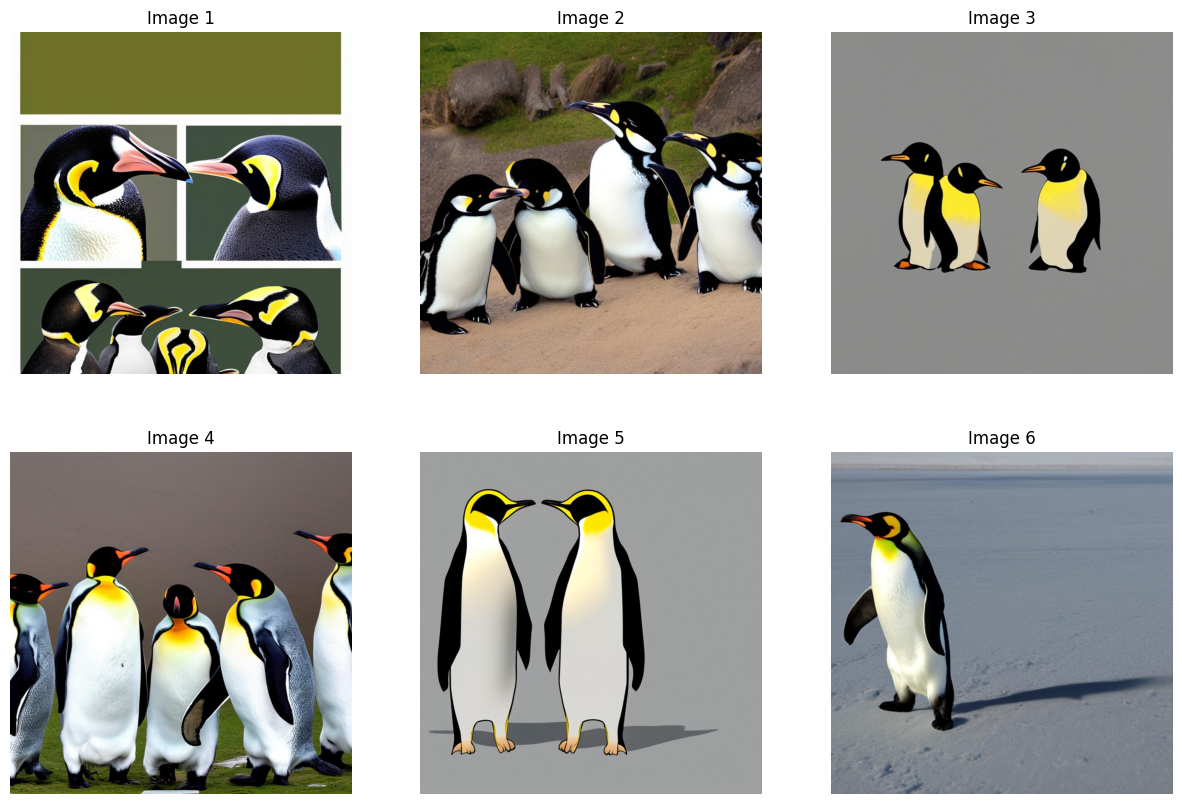

Select an image number:  3


The text used for image 3 is 'king_penguins'.


In [18]:


# 使用するモデルを設定
model_id = "stabilityai/stable-diffusion-2"

# StableDiffusionパイプライン設定
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16)

# 使用する計算機を設定（GPUがない場合は"cpu"に変更）
pipe = pipe.to("cuda")

# 生成された画像を保存するためのリスト
generated_images = []

# 画像とテキストの関連を記録する辞書
image_to_text = {}

# 各テキストに基づいて2枚ずつロゴを生成
for idx, (word, _) in enumerate(top_words_and_scores):
    prompt = f"Design a logo for {highest_scoring_NumWord} {word} "
    num_images = 2  # 各単語につき2つのイメージを生成

    for i in range(num_images):
        # 推論実行
        image = pipe(prompt, height=768, width=768).images[0]

        # 生成日時をファイル名にして保存
        date = datetime.now().strftime("%Y%m%d_%H%M%S")
        path = f"/workspace/data/output/{date}_prompt_{prompt}_{i}.jpg"
        image.save(path)

        # 画像のパスをリストに追加
        generated_images.append(path)

        # 画像とテキストの関連付け
        image_to_text[len(generated_images)] = word

        print(f"Image {i+1} saved for word '{prompt}' at {path}")

# 生成された画像を表示
plt.figure(figsize=(15, 10))  # 画像表示のための図のサイズを設定
for i, img_path in enumerate(generated_images):
    # 画像を読み込む
    img = Image.open(img_path)

    # 画像を表示
    plt.subplot(2, 3, i + 1)  # 2行3列のサブプロットに画像を配置
    plt.imshow(img)
    plt.title(f"Image {i + 1}")
    plt.axis('off')  # 軸を非表示にする

plt.show()

# ユーザーに画像の番号を選択させる
selected_image_number = int(input("Select an image number: "))

# 選択された番号に対応するテキストを表示
selected_word1 = image_to_text.get(selected_image_number)
if selected_word1 is not None:
    print(f"The text used for image {selected_image_number} is '{selected_word1}'.")
else:
    print("Invalid image number selected.")


上位3つの感受性語からどれが良いかユーザが選択

vae/diffusion_pytorch_model.safetensors not found
100%|██████████| 50/50 [00:07<00:00,  6.80it/s]


Image 1 saved for word 'Design a Playful logo for three king_penguins ' at /workspace/data/output/20240513_062623_prompt_Design a Playful logo for three king_penguins _0.jpg


100%|██████████| 50/50 [00:06<00:00,  7.17it/s]


Image 2 saved for word 'Design a Playful logo for three king_penguins ' at /workspace/data/output/20240513_062631_prompt_Design a Playful logo for three king_penguins _1.jpg


100%|██████████| 50/50 [00:06<00:00,  7.39it/s]


Image 1 saved for word 'Design a Sleek logo for three king_penguins ' at /workspace/data/output/20240513_062638_prompt_Design a Sleek logo for three king_penguins _0.jpg


100%|██████████| 50/50 [00:06<00:00,  7.19it/s]


Image 2 saved for word 'Design a Sleek logo for three king_penguins ' at /workspace/data/output/20240513_062645_prompt_Design a Sleek logo for three king_penguins _1.jpg


100%|██████████| 50/50 [00:06<00:00,  7.21it/s]


Image 1 saved for word 'Design a Cute logo for three king_penguins ' at /workspace/data/output/20240513_062652_prompt_Design a Cute logo for three king_penguins _0.jpg


100%|██████████| 50/50 [00:06<00:00,  7.37it/s]


Image 2 saved for word 'Design a Cute logo for three king_penguins ' at /workspace/data/output/20240513_062659_prompt_Design a Cute logo for three king_penguins _1.jpg


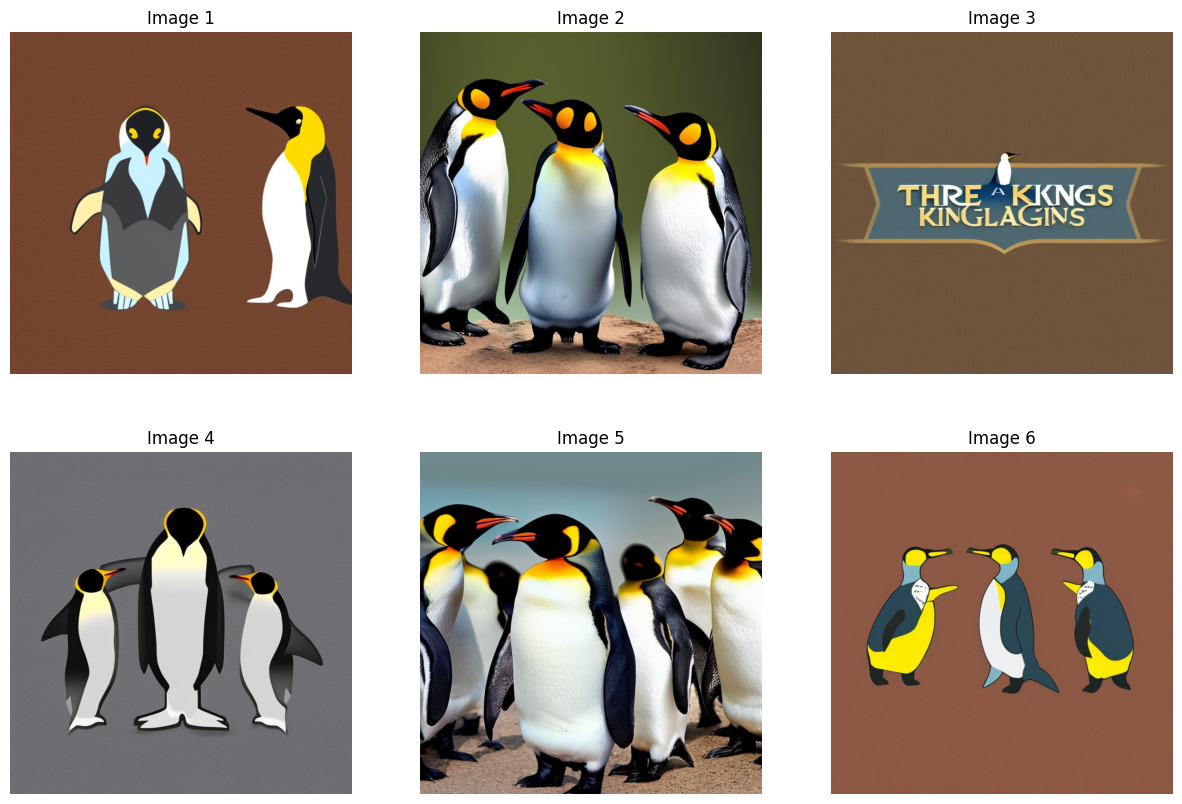

Select an image number:  6


The text used for image 6 is 'Cute'.


In [19]:


# 使用するモデルを設定
model_id = "stabilityai/stable-diffusion-2"

# StableDiffusionパイプライン設定
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16)

# 使用する計算機を設定（GPUがない場合は"cpu"に変更）
pipe = pipe.to("cuda")

# 生成された画像を保存するためのリスト
generated_images = []

# 画像とテキストの関連を記録する辞書
image_to_text = {}
Selected_image_object=selected_word1

# 各テキストに基づいて2枚ずつロゴを生成
for idx, (word, _) in enumerate(top_SensitivityWords_and_scores):
    prompt = f"Design a {word} logo for {highest_scoring_NumWord} {Selected_image_object} "
    num_images = 2  # 各単語につき2つのイメージを生成

    for i in range(num_images):
        # 推論実行
        image = pipe(prompt, height=768, width=768).images[0]

        # 生成日時をファイル名にして保存
        date = datetime.now().strftime("%Y%m%d_%H%M%S")
        path =  f"/workspace/data/output/{date}_prompt_{prompt}_{i}.jpg"
        image.save(path)

        # 画像のパスをリストに追加
        generated_images.append(path)

        # 画像とテキストの関連付け
        image_to_text[len(generated_images)] = word

        print(f"Image {i+1} saved for word '{prompt}' at {path}")

# 生成された画像を表示
plt.figure(figsize=(15, 10))  # 画像表示のための図のサイズを設定
for i, img_path in enumerate(generated_images):
    # 画像を読み込む
    img = Image.open(img_path)

    # 画像を表示
    plt.subplot(2, 3, i + 1)  # 2行3列のサブプロットに画像を配置
    plt.imshow(img)
    plt.title(f"Image {i + 1}")
    plt.axis('off')  # 軸を非表示にする

plt.show()

# ユーザーに画像の番号を選択させる
selected_image_number = int(input("Select an image number: "))

# 選択された番号に対応するテキストを表示
selected_word2 = image_to_text.get(selected_image_number)
if selected_word2 is not None:
    print(f"The text used for image {selected_image_number} is '{selected_word2}'.")
else:
    print("Invalid image number selected.")


選択した、名詞と感受性語でロゴを生成

In [ ]:
# 使用するモデルを設定
model_id = "stabilityai/stable-diffusion-2"

# StableDiffusionパイプライン設定
# pipeの設定コードをここに

# プロンプトの設定
prompt = f"Design a {selected_word2} logo for {highest_scoring_NumWord} {Selected_image_object}"

# 描画する回数を設定
num_images = 3

# 生成された画像を保存するためのリスト
generated_images = []

# イラスト生成
for i in range(num_images):
    # 推論実行
    image = pipe(prompt, height=768, width=768).images[0]

    # 生成日時をファイル名にして保存
    date = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = f"/workspace/data/output/{date}_prompt_{prompt}_{i}.jpg"
    image.save(path)

    # 画像のパスをリストに追加
    generated_images.append(path)
    print(f"Image {i+1} saved for word '{prompt}' at {path}")

# 生成された画像をまとめて表示
plt.figure(figsize=(15, 5))  # 画像表示のための図のサイズを設定
for i, img_path in enumerate(generated_images):
    img = Image.open(img_path)  # 画像を読み込む

    plt.subplot(1, num_images, i + 1)  # 1行にnum_images枚のサブプロットを配置
    plt.imshow(img)
    plt.title(f"Image {i + 1}")
    plt.axis('off')  # 軸を非表示にする

plt.show()

100%|██████████| 50/50 [00:07<00:00,  6.77it/s]


Image 1 saved for word 'Design a Cute logo for three king_penguins' at /workspace/data/output/20240513_062714_prompt_Design a Cute logo for three king_penguins_0.jpg


100%|██████████| 50/50 [00:06<00:00,  7.37it/s]
